In [ ]:
!pip install imutils
# Using shapes example from Mask R-CNN tutorial, code builds for older versions of ts and keras, so:
!pip install tensorflow==1.14.0  # add older version of TF
!pip install keras==2.2.4 # older version of Keras
!pip install -U scikit-image==0.16.2 # due to some warning with newer version

!pip install pycocotools

# import libs
import os
import re
import sys
import cv2
import glob 
import time
import json
import math
import random
import imutils
import itertools
import matplotlib
import numpy as np # linear algebra
import skimage.draw
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
from skimage.io import imread
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from imgaug import augmenters as iaa

     |████████████████████████████████| 109.3 MB 18 kB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 3.1 MB 63.4 MB/s 
     |████████████████████████████████| 488 kB 62.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you

In [ ]:
from IPython.display import clear_output

!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
!git clone https://github.com/rastislavkopal/brain-tumor-segmentation.git # load manually annotated data from git repo

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.86 MiB/s, done.
Resolving deltas: 100% (562/562), done.
Cloning into 'brain-tumor-segmentation'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 323 (delta 2), reused 314 (delta 0), pack-reused 0
Receiving objects: 100% (323/323), 5.79 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
!rm -rf brain-tumor-segmentation/.git/
!rm -rf Mask_RCNN/.git/

clear_output()

In [ ]:
# Import libraries needed for Mask R-CNN 

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")
#!python setup.py -q install

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Import COCO config  
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco
plt.rcParams['figure.facecolor'] = 'white'


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

... done downloading pretrained model!


In [ ]:
DATASET_DIR = './brain-tumor-segmentation/brain_tumor_data/'
clear_output


<function IPython.core.display.clear_output>

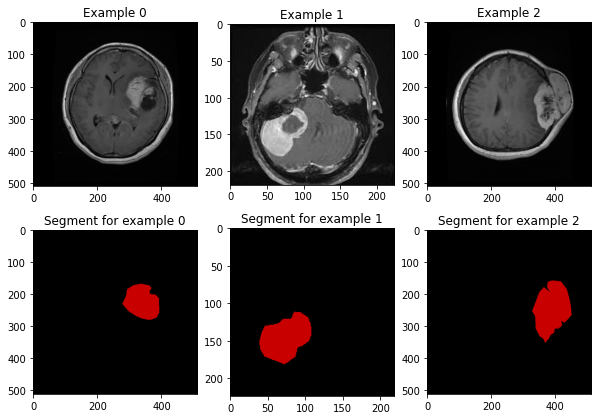

In [ ]:
examples = [Image.open(DATASET_DIR + 'train/100.jpg'),Image.open(DATASET_DIR + 'train/116.jpg'),Image.open(DATASET_DIR+'train/221.jpg')]
examplesSeg = ['100.jpg20477','116.jpg10596','221.jpg19584']

fig = plt.figure(figsize=(10,14))

for i in range(0, len(examples)):
    a = fig.add_subplot(1, 3, i+1)
    imgplot = plt.imshow(examples[i])
    a.set_title('Example '+str(i))

    ## print segment examples for images from json annotations file
with open(DATASET_DIR+'train/annotations.json') as json_file:
    data = json.load(json_file)
    for i in range(0,len(examplesSeg)):
        # load regions from json file and transform them into (x,y) coordinates
        coord = list(zip(data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_x'],data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_y'])) 
        image = Image.new("RGB", np.asarray(examples[i]).shape[0:2])
        draw = ImageDraw.Draw(image)
        draw.polygon((coord), fill=200)
        a = fig.add_subplot(2, 3, 3+i+1)
        imgplot = plt.imshow(image)
        a.set_title('Segment for example ' + str(i))

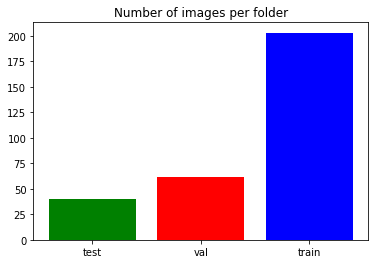

In [ ]:
# show number of data for each dir 
def showDataLayout():
    values = dict()
    for file in os.listdir(DATASET_DIR):
        values[str(file)] = len(os.listdir('./brain-tumor-segmentation/brain_tumor_data/' + file))
    plt.title('Number of images per folder')
    plt.bar(range(len(values)), list(values.values()), align='center',color=[ 'green','red', 'blue'])
    plt.xticks(range(len(values)), list(values.keys()))
    plt.show()
        
    
showDataLayout()

In [ ]:
class TrainConfig(Config):
    """Configuration for training on the brain tumor dataset.
    Derives from the base Config class and overrides values specific
    to the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = "tumor_detect"

    # Train on 1 GPU and 1 images per GPU. 1 Image per CPU since the images are 
    # of bigger size. ### Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # background + 1 class of tumor
    DETECTION_MIN_CONFIDENCE = 0.7   

    LEARNING_RATE = 0.001

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
class TumorDataset(utils.Dataset):
    """Generates the brain tumors dataset and json annotations. 
    """
    def load_brain_tumor_images(self, dataset_dir, folder):
        self.add_class("tumor", 1, "tumor")
        
        assert folder in ["train", "val", 'test']
        
        dataset_dir = os.path.join(dataset_dir,folder)
        
        annotations = json.load(open(os.path.join(dataset_dir,'annotations.json')))

        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        
        for i in annotations:
            polygons = [r['shape_attributes'] for r in i['regions']] # get segmented regions from json file
            
            image_path = os.path.join(dataset_dir, i['filename']) # load correspending image for loaded json object and save it's size
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            # set jsons's 'filename' property as unique identifier since its same as original image name
            # using only 'tumor' class/object
            self.add_image('tumor', image_id=i['filename'], width=width, height=height, path=image_path, polygons=polygons)

            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        This function loads the image from a file with given image_id
        """
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    
   # info = self.image_info[image_id]
   # bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
   # image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
   # image = image * bg_color.astype(np.uint8)
   # for shape, color, dims in info['shapes']:
   #     image = self.draw_shape(image, shape, dims, color)
   # return image

    def load_mask(self, image_id):
        """Return instance masks for brain image of the given ID"""
        # If not a tumor dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count] 
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],dtype=np.uint8)

        for i, p in enumerate(image_info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [ ]:
# Train dataset generator
dataset_train = TumorDataset()
dataset_train.load_brain_tumor_images(DATASET_DIR,'train')
dataset_train.prepare()

# Validation dataset
dataset_val = TumorDataset()
dataset_val.load_brain_tumor_images(DATASET_DIR,'val')
dataset_val.prepare()

# Test dataset
dataset_test = TumorDataset()
dataset_test.load_brain_tumor_images(DATASET_DIR,'test')
dataset_test.prepare()

In [ ]:
pip install 'h5py==2.10.0' --force-reinstall


  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=8, 
            layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/tumor_detect20211009T1009/mask_rcnn_tumor_detect_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker



Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

  1/100 [..............................] - ETA: 2:38:58 - loss: 3.4090 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.5258 - mrcnn_bbox_loss: 1.3289 - mrcnn_mask_loss: 1.1681

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 2:00:48 - loss: 3.1954 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3342 - mrcnn_class_loss: 0.3796 - mrcnn_bbox_loss: 1.2586 - mrcnn_mask_loss: 1.1867

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:50:05 - loss: 4.7942 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 2.8172 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.8390 - mrcnn_mask_loss: 0.7912

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:42:28 - loss: 5.3667 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 3.8439 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.6293 - mrcnn_mask_loss: 0.5934

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:37:50 - loss: 4.8679 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 3.1707 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.7016 - mrcnn_mask_loss: 0.7317

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:34:20 - loss: 4.4988 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 2.7163 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.7279 - mrcnn_mask_loss: 0.8150

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:31:16 - loss: 4.2366 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 2.3737 - mrcnn_class_loss: 0.1548 - mrcnn_bbox_loss: 0.7845 - mrcnn_mask_loss: 0.8647

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:29:13 - loss: 3.9961 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 2.1143 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.7971 - mrcnn_mask_loss: 0.8930

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:27:18 - loss: 3.7931 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.8972 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.7936 - mrcnn_mask_loss: 0.9079

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:25:42 - loss: 3.6086 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.7221 - mrcnn_class_loss: 0.1516 - mrcnn_bbox_loss: 0.7764 - mrcnn_mask_loss: 0.9159

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:24:02 - loss: 3.4095 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.5764 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.7424 - mrcnn_mask_loss: 0.9122

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:22:30 - loss: 3.2190 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.4553 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.6919 - mrcnn_mask_loss: 0.9066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:21:22 - loss: 3.1843 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 1.3842 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.9051

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:20:02 - loss: 3.1342 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.3189 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.9011

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:19:18 - loss: 3.0554 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 1.2371 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.7103 - mrcnn_mask_loss: 0.9001

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:18:09 - loss: 2.9835 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1649 - mrcnn_class_loss: 0.1712 - mrcnn_bbox_loss: 0.7187 - mrcnn_mask_loss: 0.8975

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:17:03 - loss: 2.9148 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.1012 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.7322 - mrcnn_mask_loss: 0.8879

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:15:57 - loss: 2.8424 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.0444 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.7340 - mrcnn_mask_loss: 0.8778

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:14:48 - loss: 2.8200 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.0377 - mrcnn_class_loss: 0.1511 - mrcnn_bbox_loss: 0.7356 - mrcnn_mask_loss: 0.8647

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:13:38 - loss: 2.7864 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 1.0259 - mrcnn_class_loss: 0.1465 - mrcnn_bbox_loss: 0.7288 - mrcnn_mask_loss: 0.8519

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:12:35 - loss: 2.7202 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.9813 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.7214 - mrcnn_mask_loss: 0.8438

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:11:31 - loss: 2.6536 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.9407 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.7087 - mrcnn_mask_loss: 0.8357

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:10:29 - loss: 2.6722 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.9561 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.7241 - mrcnn_mask_loss: 0.8272

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:09:26 - loss: 2.6663 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.9589 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.7269 - mrcnn_mask_loss: 0.8189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:08:23 - loss: 2.6179 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.9280 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.7243 - mrcnn_mask_loss: 0.8090

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:07:29 - loss: 2.5769 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.8996 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.7239 - mrcnn_mask_loss: 0.8016

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:06:29 - loss: 2.5190 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.8720 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.7089 - mrcnn_mask_loss: 0.7894

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 1:05:27 - loss: 2.4617 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.8455 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.6937 - mrcnn_mask_loss: 0.7773

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 1:04:23 - loss: 2.4639 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.8340 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.7095 - mrcnn_mask_loss: 0.7734

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 1:03:25 - loss: 2.4568 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.8228 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.7161 - mrcnn_mask_loss: 0.7697

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 1:02:25 - loss: 2.4301 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.8065 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.7057 - mrcnn_mask_loss: 0.7739

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 1:01:31 - loss: 2.3986 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.7912 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.6895 - mrcnn_mask_loss: 0.7779

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 1:00:38 - loss: 2.3853 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.7769 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.6989 - mrcnn_mask_loss: 0.7719

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 59:43 - loss: 2.3667 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7621 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.7035 - mrcnn_mask_loss: 0.7661  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 58:50 - loss: 2.3627 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.7499 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.7208 - mrcnn_mask_loss: 0.7592

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 57:56 - loss: 2.3607 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.7350 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.7352 - mrcnn_mask_loss: 0.7568

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 57:03 - loss: 2.3475 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.7241 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.7389 - mrcnn_mask_loss: 0.7520

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 56:09 - loss: 2.3061 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.7243 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.7195 - mrcnn_mask_loss: 0.7322

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 55:10 - loss: 2.2908 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.7106 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.7197 - mrcnn_mask_loss: 0.7298

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 54:10 - loss: 2.2573 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.6935 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.7122 - mrcnn_mask_loss: 0.7241

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 53:13 - loss: 2.2347 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.6812 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.7060 - mrcnn_mask_loss: 0.7212

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 52:15 - loss: 2.2130 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.6682 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.7053 - mrcnn_mask_loss: 0.7151

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 51:16 - loss: 2.1795 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6535 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.6938 - mrcnn_mask_loss: 0.7101

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 50:17 - loss: 2.1706 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.6472 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.6942 - mrcnn_mask_loss: 0.7070

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 49:20 - loss: 2.1408 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.6353 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.6839 - mrcnn_mask_loss: 0.7014

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 48:24 - loss: 2.1365 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.6264 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.6960 - mrcnn_mask_loss: 0.6957

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 47:28 - loss: 2.1203 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6197 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.6896 - mrcnn_mask_loss: 0.6930

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 46:31 - loss: 2.0993 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6102 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.6849 - mrcnn_mask_loss: 0.6879

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 45:35 - loss: 2.0868 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6019 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.6871 - mrcnn_mask_loss: 0.6826

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 44:39 - loss: 2.0837 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5939 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.6907 - mrcnn_mask_loss: 0.6821

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 43:43 - loss: 2.0629 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.6853 - mrcnn_mask_loss: 0.6778

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 42:47 - loss: 2.0599 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5741 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.6953 - mrcnn_mask_loss: 0.6747

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 41:52 - loss: 2.0503 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.6923 - mrcnn_mask_loss: 0.6747

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 40:57 - loss: 2.0369 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5591 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.6904 - mrcnn_mask_loss: 0.6714

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 40:01 - loss: 2.0213 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5499 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.6877 - mrcnn_mask_loss: 0.6681

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 39:07 - loss: 2.0409 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.6944 - mrcnn_mask_loss: 0.6679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 38:12 - loss: 2.0238 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.6890 - mrcnn_mask_loss: 0.6646

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 37:18 - loss: 2.0232 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5513 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.6910 - mrcnn_mask_loss: 0.6652

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 36:22 - loss: 2.0351 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5601 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.6940 - mrcnn_mask_loss: 0.6659

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 35:28 - loss: 2.0773 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5974 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.6992 - mrcnn_mask_loss: 0.6668

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 34:34 - loss: 2.0696 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5902 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.6964 - mrcnn_mask_loss: 0.6673

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 33:39 - loss: 2.0635 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5841 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.6997 - mrcnn_mask_loss: 0.6642

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 32:44 - loss: 2.0884 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6078 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.6653

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 31:48 - loss: 2.0869 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6024 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.7069 - mrcnn_mask_loss: 0.6632

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 30:53 - loss: 2.0752 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.7052 - mrcnn_mask_loss: 0.6603

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 29:58 - loss: 2.0605 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.5896 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.6995 - mrcnn_mask_loss: 0.6577

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 29:03 - loss: 2.0507 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.6971 - mrcnn_mask_loss: 0.6556

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 28:08 - loss: 2.0589 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5904 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.7034 - mrcnn_mask_loss: 0.6526

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 27:14 - loss: 2.0525 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5850 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.7047 - mrcnn_mask_loss: 0.6507

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 26:19 - loss: 2.0375 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5787 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.6991 - mrcnn_mask_loss: 0.6480

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 25:25 - loss: 2.0261 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5745 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.6959 - mrcnn_mask_loss: 0.6448

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 24:31 - loss: 2.0244 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5775 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.6950 - mrcnn_mask_loss: 0.6418

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 23:37 - loss: 2.0165 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5730 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.6935 - mrcnn_mask_loss: 0.6402

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 22:43 - loss: 2.0050 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.6901 - mrcnn_mask_loss: 0.6385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 21:49 - loss: 1.9935 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5633 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.6864 - mrcnn_mask_loss: 0.6356

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 20:56 - loss: 1.9845 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5594 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.6846 - mrcnn_mask_loss: 0.6333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 20:02 - loss: 1.9843 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5606 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.6834 - mrcnn_mask_loss: 0.6321

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 19:10 - loss: 1.9716 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5558 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.6781 - mrcnn_mask_loss: 0.6303

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 18:17 - loss: 1.9648 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5568 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.6747 - mrcnn_mask_loss: 0.6269

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 17:23 - loss: 1.9527 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5524 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.6693 - mrcnn_mask_loss: 0.6251

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 16:30 - loss: 1.9491 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.6741 - mrcnn_mask_loss: 0.6228

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 15:37 - loss: 1.9413 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.6692 - mrcnn_mask_loss: 0.6216

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 14:44 - loss: 1.9427 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5475 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.6698 - mrcnn_mask_loss: 0.6197

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 13:52 - loss: 1.9323 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.6650 - mrcnn_mask_loss: 0.6164

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 12:59 - loss: 1.9296 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5406 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.6673 - mrcnn_mask_loss: 0.6154

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 12:07 - loss: 1.9222 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.6675 - mrcnn_mask_loss: 0.6129

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 11:14 - loss: 1.9162 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5374 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.6622 - mrcnn_mask_loss: 0.6112

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 10:22 - loss: 1.9073 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.6603 - mrcnn_mask_loss: 0.6089

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 9:30 - loss: 1.8994 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.6076 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:38 - loss: 1.8931 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.6589 - mrcnn_mask_loss: 0.6048

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:46 - loss: 1.8823 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5215 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.6549 - mrcnn_mask_loss: 0.6016

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 6:54 - loss: 1.8717 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.6516 - mrcnn_mask_loss: 0.5995

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 6:02 - loss: 1.8765 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.6538 - mrcnn_mask_loss: 0.5980

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 5:10 - loss: 1.8650 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.6501 - mrcnn_mask_loss: 0.5954

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:18 - loss: 1.8528 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5111 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.6450 - mrcnn_mask_loss: 0.5927

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:26 - loss: 1.8510 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.6442 - mrcnn_mask_loss: 0.5920

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:34 - loss: 1.8514 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5112 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.6436 - mrcnn_mask_loss: 0.5905

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:43 - loss: 1.8435 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5097 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.6411 - mrcnn_mask_loss: 0.5872

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 51s - loss: 1.8405 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5089 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.6398 - mrcnn_mask_loss: 0.5871 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 5232s 52s/step - loss: 1.8346 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5068 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.6370 - mrcnn_mask_loss: 0.5858 - val_loss: 0.8840 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.4086 - val_mrcnn_class_loss: 0.0158 - val_mrcnn_bbox_loss: 0.1792 - val_mrcnn_mask_loss: 0.2736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 2/8
  1/100 [..............................] - ETA: 1:22:11 - loss: 0.7649 - rpn_class_loss: 3.5515e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.4338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:21:14 - loss: 0.7362 - rpn_class_loss: 4.9978e-04 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.3488

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:19:38 - loss: 0.9594 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.2938 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.3222    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:18:28 - loss: 0.9868 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.3151 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.3722

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:17:21 - loss: 1.0345 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3287 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.3575

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:16:28 - loss: 0.9413 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2763 - mrcnn_mask_loss: 0.3579

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:15:30 - loss: 1.0841 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3186 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.3683

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:14:32 - loss: 1.0643 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.3538

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:13:41 - loss: 1.0338 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3103 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.3411

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:12:50 - loss: 1.0106 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3067 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.3327 - mrcnn_mask_loss: 0.3370

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:11:54 - loss: 0.9928 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2835 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.3301 - mrcnn_mask_loss: 0.3409

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:11:01 - loss: 0.9792 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2780 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.3395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:10:36 - loss: 0.9756 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.3439 - mrcnn_mask_loss: 0.3294

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:09:46 - loss: 0.9458 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2482 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.3344 - mrcnn_mask_loss: 0.3227

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:08:57 - loss: 0.9279 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2340 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.3354 - mrcnn_mask_loss: 0.3187

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:08:08 - loss: 0.9111 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.3194

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:07:17 - loss: 0.9920 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2443 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.3415

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:06:26 - loss: 0.9731 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2349 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.3583 - mrcnn_mask_loss: 0.3344

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:05:34 - loss: 0.9882 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2394 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.3652 - mrcnn_mask_loss: 0.3349

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:04:45 - loss: 0.9666 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.3305

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:03:56 - loss: 0.9439 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.3258

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:03:07 - loss: 0.9677 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.3534 - mrcnn_mask_loss: 0.3397

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:02:18 - loss: 0.9709 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2468 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.3417 - mrcnn_mask_loss: 0.3367

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:01:29 - loss: 0.9712 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2450 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3432 - mrcnn_mask_loss: 0.3361

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:00:40 - loss: 1.0319 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2822 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.3435

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 59:52 - loss: 1.0085 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.3469 - mrcnn_mask_loss: 0.3385  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 59:03 - loss: 0.9984 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.3355

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 58:13 - loss: 0.9941 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.3400 - mrcnn_mask_loss: 0.3328

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 57:25 - loss: 0.9867 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 0.3294

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 56:35 - loss: 1.0060 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3411 - mrcnn_mask_loss: 0.3318

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 55:47 - loss: 1.0228 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2823 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.3553 - mrcnn_mask_loss: 0.3331

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 54:59 - loss: 1.0113 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2763 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.3302

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 54:11 - loss: 1.0591 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3056 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.3709 - mrcnn_mask_loss: 0.3305

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 53:22 - loss: 1.0414 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2997 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.3634 - mrcnn_mask_loss: 0.3268

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 52:32 - loss: 1.0697 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.3799 - mrcnn_mask_loss: 0.3348

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 51:44 - loss: 1.0710 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3026 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.3359

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 50:54 - loss: 1.0775 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3039 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.3362

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 50:06 - loss: 1.0980 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3229 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.3351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 49:16 - loss: 1.0850 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.3165 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.3315

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 48:27 - loss: 1.0836 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3112 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.3351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 47:39 - loss: 1.0799 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.3824 - mrcnn_mask_loss: 0.3335

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 46:51 - loss: 1.0752 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3063 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.3802 - mrcnn_mask_loss: 0.3322

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 46:02 - loss: 1.0700 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3014 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.3313

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 45:13 - loss: 1.0575 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2958 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.3762 - mrcnn_mask_loss: 0.3276

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 44:23 - loss: 1.0678 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2987 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3842 - mrcnn_mask_loss: 0.3272

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 43:34 - loss: 1.0599 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2952 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.3254

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 42:46 - loss: 1.0506 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2926 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.3769 - mrcnn_mask_loss: 0.3228

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 41:57 - loss: 1.0426 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2877 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.3221

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 41:08 - loss: 1.0594 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.3324

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 40:19 - loss: 1.0614 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2891 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.3319

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 39:30 - loss: 1.0481 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2838 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.3280

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 38:42 - loss: 1.0366 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2801 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.3737 - mrcnn_mask_loss: 0.3255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 37:53 - loss: 1.0484 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3799 - mrcnn_mask_loss: 0.3275

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 37:04 - loss: 1.0489 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2807 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.3322

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 36:16 - loss: 1.0588 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2825 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.3319

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 35:27 - loss: 1.0453 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2782 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.3285

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 34:39 - loss: 1.0674 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3131 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.3227

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 33:50 - loss: 1.0685 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3136 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.3748 - mrcnn_mask_loss: 0.3242

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 33:02 - loss: 1.0773 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3162 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.3256

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 32:13 - loss: 1.0758 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3168 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.3248

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 31:24 - loss: 1.1114 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3440 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.3259

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 30:36 - loss: 1.1180 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3417 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.3360

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 29:47 - loss: 1.1333 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3465 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.3389

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 28:59 - loss: 1.1427 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3487 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3946 - mrcnn_mask_loss: 0.3403

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 28:10 - loss: 1.1444 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3483 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.3383

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 27:22 - loss: 1.1504 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.3394

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 26:33 - loss: 1.1882 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3736 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.3425

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 25:45 - loss: 1.1897 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3749 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.3427

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 24:57 - loss: 1.1993 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3745 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.3489

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 24:08 - loss: 1.1954 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3728 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.3470

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 23:20 - loss: 1.2022 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.3471

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 22:32 - loss: 1.2223 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.3487

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 21:43 - loss: 1.2132 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3805 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.3459

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 20:55 - loss: 1.2165 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.4189 - mrcnn_mask_loss: 0.3492

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 20:07 - loss: 1.2085 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3750 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.4167 - mrcnn_mask_loss: 0.3471

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 19:18 - loss: 1.2041 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3717 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.3470

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 18:30 - loss: 1.2441 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4198 - mrcnn_mask_loss: 0.3518

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 17:42 - loss: 1.2337 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.3490

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 16:54 - loss: 1.2236 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.4127 - mrcnn_mask_loss: 0.3463

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 16:05 - loss: 1.2123 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3904 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.3440

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 15:17 - loss: 1.2100 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3888 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.4082 - mrcnn_mask_loss: 0.3436

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 14:29 - loss: 1.2338 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4068 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.3453

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 13:41 - loss: 1.2455 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.3474

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 12:53 - loss: 1.2343 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.3449

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 12:05 - loss: 1.2294 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4065 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.3434

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 11:16 - loss: 1.2240 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.3421

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 10:28 - loss: 1.2230 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4080 - mrcnn_mask_loss: 0.3410

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 9:40 - loss: 1.2281 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.3426 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 8:51 - loss: 1.2302 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.3423

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:03 - loss: 1.2245 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4066 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.4072 - mrcnn_mask_loss: 0.3406

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:15 - loss: 1.2265 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.3381

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 6:26 - loss: 1.2230 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.4042 - mrcnn_mask_loss: 0.3371

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 5:38 - loss: 1.2215 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4085 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.4053 - mrcnn_mask_loss: 0.3374

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 4:50 - loss: 1.2209 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4095 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.4039 - mrcnn_mask_loss: 0.3374

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:01 - loss: 1.2189 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.4036 - mrcnn_mask_loss: 0.3371

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:13 - loss: 1.2181 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4123 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.4009 - mrcnn_mask_loss: 0.3349

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:25 - loss: 1.2154 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.3338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:36 - loss: 1.2103 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.3337

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 48s - loss: 1.2128 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4082 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.3337 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 4915s 49s/step - loss: 1.2076 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.3997 - mrcnn_mask_loss: 0.3324 - val_loss: 0.8207 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.1895 - val_mrcnn_class_loss: 0.0651 - val_mrcnn_bbox_loss: 0.2854 - val_mrcnn_mask_loss: 0.2739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 3/8
  1/100 [..............................] - ETA: 1:29:10 - loss: 1.2289 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.3912

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:23:32 - loss: 0.9400 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1622 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.3274

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:21:25 - loss: 1.3848 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2725 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.4564 - mrcnn_mask_loss: 0.5701

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:19:44 - loss: 1.2673 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2893 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.5019

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:18:26 - loss: 1.2969 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3815 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.4550

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:17:21 - loss: 1.1932 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3464 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.4189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:16:28 - loss: 1.1683 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.3984

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:15:34 - loss: 1.2409 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.4544

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:14:44 - loss: 1.3400 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3440 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.4628 - mrcnn_mask_loss: 0.4464

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:13:50 - loss: 1.2963 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3505 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.4363 - mrcnn_mask_loss: 0.4263

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:12:55 - loss: 1.3644 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3719 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4216

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:12:01 - loss: 1.3159 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3498 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.4633 - mrcnn_mask_loss: 0.4171

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:11:36 - loss: 1.3656 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.3706 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.4832 - mrcnn_mask_loss: 0.4203

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:10:46 - loss: 1.3741 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.3757 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.4187

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:09:51 - loss: 1.3635 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3601 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.4059

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:09:01 - loss: 1.3532 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.3540 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.4978 - mrcnn_mask_loss: 0.4029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:08:13 - loss: 1.3385 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.3394 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.4089

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:07:21 - loss: 1.3321 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.3352 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.4848 - mrcnn_mask_loss: 0.4124

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:06:28 - loss: 1.3151 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4013

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:05:37 - loss: 1.2848 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.3261 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.3922

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:04:47 - loss: 1.2542 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.4613 - mrcnn_mask_loss: 0.3808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:03:59 - loss: 1.2297 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3030 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.4527 - mrcnn_mask_loss: 0.3782

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:03:08 - loss: 1.2363 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.3115 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.3760

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:02:18 - loss: 1.2181 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.4441 - mrcnn_mask_loss: 0.3683

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:01:25 - loss: 1.2612 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3391 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.4477 - mrcnn_mask_loss: 0.3762

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:00:39 - loss: 1.2265 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.3283 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.3674

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 59:49 - loss: 1.2190 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.3615  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 59:01 - loss: 1.2110 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.3323 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.3583

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 58:11 - loss: 1.2188 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3394 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.4224 - mrcnn_mask_loss: 0.3643

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 57:22 - loss: 1.2317 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.3679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 56:32 - loss: 1.2407 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.3588 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.4200 - mrcnn_mask_loss: 0.3660

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 55:44 - loss: 1.2229 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.3598

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 54:54 - loss: 1.2296 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.3522 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.3603

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 54:05 - loss: 1.2196 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.3506 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.3599

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 53:16 - loss: 1.2118 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3458 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.3592

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 52:26 - loss: 1.2059 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3448 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.3570

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 51:36 - loss: 1.1889 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3425 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.4053 - mrcnn_mask_loss: 0.3511

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 50:46 - loss: 1.1789 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3377 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.3513

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 49:56 - loss: 1.1981 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3399 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.4133 - mrcnn_mask_loss: 0.3539

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 49:06 - loss: 1.1832 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3340 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.3530

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 48:16 - loss: 1.1823 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.3530

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 47:27 - loss: 1.1655 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.3259 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.4043 - mrcnn_mask_loss: 0.3476

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 46:38 - loss: 1.1679 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.3496

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 45:49 - loss: 1.1740 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.3297 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.4051 - mrcnn_mask_loss: 0.3512

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 45:00 - loss: 1.1775 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3310 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.4087 - mrcnn_mask_loss: 0.3500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 44:10 - loss: 1.1683 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.3262 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.4046 - mrcnn_mask_loss: 0.3503

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 43:20 - loss: 1.1543 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3217 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.4000 - mrcnn_mask_loss: 0.3458

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 42:31 - loss: 1.1501 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.3469

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 41:42 - loss: 1.1580 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3214 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.4027 - mrcnn_mask_loss: 0.3464

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 40:53 - loss: 1.1490 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.3198 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.3439

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 40:03 - loss: 1.1527 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3142 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.3444

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 39:14 - loss: 1.1370 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.3403

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 38:24 - loss: 1.1282 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3100 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.3368

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 37:34 - loss: 1.1246 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.3945 - mrcnn_mask_loss: 0.3364

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 36:46 - loss: 1.1254 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.3350

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 35:57 - loss: 1.1203 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.3352

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 35:07 - loss: 1.1150 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3008 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.3957 - mrcnn_mask_loss: 0.3331

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 34:18 - loss: 1.1068 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3016 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.3298

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 33:28 - loss: 1.1224 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3035 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.3945 - mrcnn_mask_loss: 0.3352

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 32:39 - loss: 1.1141 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3003 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.3917 - mrcnn_mask_loss: 0.3336

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 31:50 - loss: 1.1184 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2983 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.3929 - mrcnn_mask_loss: 0.3361

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 31:01 - loss: 1.1081 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2954 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.3339

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 30:12 - loss: 1.1008 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2929 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.3303

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 29:23 - loss: 1.1068 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2922 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.3336

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 28:34 - loss: 1.0965 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2898 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.3308

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 27:44 - loss: 1.0982 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2892 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.3324

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 26:55 - loss: 1.0963 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2869 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.3316

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 26:07 - loss: 1.0861 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2833 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.3283

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 25:17 - loss: 1.0842 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.3297

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 24:28 - loss: 1.0760 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2777 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.3809 - mrcnn_mask_loss: 0.3270

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 23:39 - loss: 1.0724 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2762 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.3262

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 22:50 - loss: 1.0691 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.3254

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 22:01 - loss: 1.0760 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.3276

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 21:11 - loss: 1.0696 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.3278

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 20:22 - loss: 1.0649 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.3254

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 19:33 - loss: 1.0581 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.3757 - mrcnn_mask_loss: 0.3243

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 18:44 - loss: 1.0565 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.3743 - mrcnn_mask_loss: 0.3246

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 17:55 - loss: 1.0601 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.3262

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 17:07 - loss: 1.0682 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.3758 - mrcnn_mask_loss: 0.3262

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 16:18 - loss: 1.0591 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.3238

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 15:29 - loss: 1.0617 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2723 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.3737 - mrcnn_mask_loss: 0.3220

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 14:40 - loss: 1.0576 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.3712 - mrcnn_mask_loss: 0.3219

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 13:51 - loss: 1.0550 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.3204

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 13:02 - loss: 1.0576 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.2745 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.3704 - mrcnn_mask_loss: 0.3200

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 12:13 - loss: 1.0549 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.3686 - mrcnn_mask_loss: 0.3193

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 11:24 - loss: 1.0537 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.3177

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 10:36 - loss: 1.0512 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.2745 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.3171

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 9:47 - loss: 1.0466 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.3645 - mrcnn_mask_loss: 0.3155 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 8:58 - loss: 1.0417 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.3131

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:09 - loss: 1.0360 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.3123

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:20 - loss: 1.0319 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.3586 - mrcnn_mask_loss: 0.3114

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 6:31 - loss: 1.0299 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.3110

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 5:42 - loss: 1.0253 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.3092

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 4:53 - loss: 1.0187 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2710 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.3070

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:04 - loss: 1.0135 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3055

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:15 - loss: 1.0075 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.3475 - mrcnn_mask_loss: 0.3047

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:26 - loss: 1.0422 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2773 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.3143

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:37 - loss: 1.0361 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2756 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.3125

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 48s - loss: 1.0617 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.3652 - mrcnn_mask_loss: 0.3135 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 4971s 50s/step - loss: 1.0549 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2919 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.3120 - val_loss: 1.7065 - val_rpn_class_loss: 0.0077 - val_rpn_bbox_loss: 0.6880 - val_mrcnn_class_loss: 0.0486 - val_mrcnn_bbox_loss: 0.5666 - val_mrcnn_mask_loss: 0.3956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 4/8
  1/100 [..............................] - ETA: 1:28:40 - loss: 1.1292 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.8039 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.1243

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:24:04 - loss: 1.8841 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.8103 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.6260 - mrcnn_mask_loss: 0.4101

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:22:05 - loss: 1.4822 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6053 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.4978 - mrcnn_mask_loss: 0.3328

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:20:40 - loss: 1.7633 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8652 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.3450

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:19:27 - loss: 1.7366 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.8893 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.3267

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:18:34 - loss: 1.5761 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.8241 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.2919

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:17:33 - loss: 1.4707 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7179 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.2979

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:16:35 - loss: 1.3705 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.6539 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.3578 - mrcnn_mask_loss: 0.2822

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:15:35 - loss: 1.3938 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.6400 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.3181

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:14:41 - loss: 1.3542 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.3093

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:13:47 - loss: 1.3058 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6116 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.2917

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:12:57 - loss: 1.2387 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5666 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.2827

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:12:29 - loss: 1.1837 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5354 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.2711

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:11:28 - loss: 1.1920 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.2953

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:10:33 - loss: 1.1500 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4998 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2919 - mrcnn_mask_loss: 0.2857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:09:36 - loss: 1.1117 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.2750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:08:41 - loss: 1.1841 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4886 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.2819

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:07:46 - loss: 1.1373 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3283 - mrcnn_mask_loss: 0.2732

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:06:54 - loss: 1.1448 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4653 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.2731

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:06:01 - loss: 1.1102 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.2660

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:05:10 - loss: 1.1538 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.3404 - mrcnn_mask_loss: 0.2857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:04:16 - loss: 1.1823 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4552 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.3621 - mrcnn_mask_loss: 0.2902

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:03:22 - loss: 1.1805 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4594 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3635 - mrcnn_mask_loss: 0.2834

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:02:31 - loss: 1.1676 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4574 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.2808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:01:41 - loss: 1.1731 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.2826

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:00:52 - loss: 1.1821 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4502 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.2924

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:00:02 - loss: 1.1598 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.3567 - mrcnn_mask_loss: 0.2876

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 59:10 - loss: 1.1435 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4357 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.3506 - mrcnn_mask_loss: 0.2820  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 58:20 - loss: 1.1244 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.2771

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 57:30 - loss: 1.1235 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4253 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.3449 - mrcnn_mask_loss: 0.2773

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 56:41 - loss: 1.1220 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4160 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.2796

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 55:50 - loss: 1.0997 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.2753

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 54:59 - loss: 1.0805 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3963 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.2723

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 54:10 - loss: 1.0638 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3896 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 0.2679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 53:19 - loss: 1.1214 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3402 - mrcnn_mask_loss: 0.2952

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 52:28 - loss: 1.1128 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.2962

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 51:38 - loss: 1.0982 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4032 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.2925

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 50:48 - loss: 1.0784 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3939 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.2892

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 49:58 - loss: 1.0642 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3866 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.2860

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 49:07 - loss: 1.0921 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.2968

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 48:17 - loss: 1.0749 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3967 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.2925

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 47:27 - loss: 1.0593 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3918 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.2896

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 46:37 - loss: 1.1143 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.2942

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 45:48 - loss: 1.0948 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.2909

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 44:59 - loss: 1.0827 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.2878

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 44:09 - loss: 1.0643 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.2842

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 43:20 - loss: 1.0572 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 0.2814

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 42:30 - loss: 1.0821 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4198 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.2842

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 41:40 - loss: 1.0990 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4230 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.2906

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 40:51 - loss: 1.0848 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4158 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.2876

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 40:02 - loss: 1.0777 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4122 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.2858

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 39:14 - loss: 1.0686 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4088 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3127 - mrcnn_mask_loss: 0.2832

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 38:25 - loss: 1.0741 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4121 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.2840

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 37:36 - loss: 1.0824 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.2901

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 36:47 - loss: 1.0804 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.2912

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 35:58 - loss: 1.0690 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3999 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3155 - mrcnn_mask_loss: 0.2889

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 35:08 - loss: 1.0615 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2877

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 34:19 - loss: 1.0610 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3948 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.2882

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 33:30 - loss: 1.0600 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.3168 - mrcnn_mask_loss: 0.2873

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 32:41 - loss: 1.0536 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3878 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.2865

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 31:52 - loss: 1.0496 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3854 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.2852

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 31:03 - loss: 1.0385 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3800 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.2837

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 30:14 - loss: 1.0409 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3808 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 0.2837

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 29:25 - loss: 1.0332 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3764 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3120 - mrcnn_mask_loss: 0.2820

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 28:36 - loss: 1.0253 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3717 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.3108 - mrcnn_mask_loss: 0.2802

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 27:47 - loss: 1.0169 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3686 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.2791

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 26:57 - loss: 1.0113 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3647 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.2778

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 26:08 - loss: 1.0109 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3645 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2772

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 25:19 - loss: 1.0087 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3604 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.2770

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 24:29 - loss: 0.9990 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.2752

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 23:40 - loss: 0.9965 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3584 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.2733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 22:51 - loss: 0.9878 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.2712

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 22:02 - loss: 1.0020 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3553 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.2776

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 21:13 - loss: 0.9963 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2765

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 20:24 - loss: 0.9906 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.2742

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 19:34 - loss: 0.9844 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.3031 - mrcnn_mask_loss: 0.2724

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 18:45 - loss: 0.9932 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3510 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.2735

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 17:56 - loss: 1.0022 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.3097 - mrcnn_mask_loss: 0.2795

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 17:07 - loss: 0.9996 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3488 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.2783

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 16:18 - loss: 0.9916 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3462 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.2763

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 15:29 - loss: 0.9907 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3436 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.2781

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 14:40 - loss: 0.9935 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3443 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.2790

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 13:51 - loss: 0.9935 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3516 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.2757

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 13:02 - loss: 0.9865 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3482 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.2743

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 12:13 - loss: 1.0100 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3589 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.2787

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 11:24 - loss: 1.0064 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.2786

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 10:35 - loss: 1.0098 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3536 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.2801

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 9:46 - loss: 1.0149 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.2811 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 8:57 - loss: 1.0262 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3550 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.2829

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:08 - loss: 1.0407 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3620 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.2870

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:19 - loss: 1.0378 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3593 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3294 - mrcnn_mask_loss: 0.2873

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 6:30 - loss: 1.0362 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3566 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.2883

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 5:41 - loss: 1.0468 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3634 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.2885

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 4:53 - loss: 1.0500 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3624 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.2887

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:04 - loss: 1.0448 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3598 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.3372 - mrcnn_mask_loss: 0.2868

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:15 - loss: 1.0411 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3568 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.2864

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:26 - loss: 1.0719 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3800 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.2880

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:37 - loss: 1.0698 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3787 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.3425 - mrcnn_mask_loss: 0.2876

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 48s - loss: 1.0659 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3752 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.2866 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 4966s 50s/step - loss: 1.0595 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3415 - mrcnn_mask_loss: 0.2849 - val_loss: 1.0810 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.2865 - val_mrcnn_class_loss: 0.0540 - val_mrcnn_bbox_loss: 0.3841 - val_mrcnn_mask_loss: 0.3452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 5/8
  1/100 [..............................] - ETA: 1:19:10 - loss: 0.5774 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.1277

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:18:49 - loss: 1.6090 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.9575 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.2413

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:17:48 - loss: 1.3432 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.7544 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:17:04 - loss: 1.1258 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5724 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.2254

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:16:10 - loss: 1.2488 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.2604

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:15:28 - loss: 1.1021 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4546 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.2351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:14:41 - loss: 1.0124 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.4000 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.2165

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:14:02 - loss: 0.9715 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.3689 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3492 - mrcnn_mask_loss: 0.2195

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:13:18 - loss: 0.9596 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3535 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.3634 - mrcnn_mask_loss: 0.2067

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:13:11 - loss: 1.0025 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3400 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.2242

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:12:19 - loss: 0.9975 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3459 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.3758 - mrcnn_mask_loss: 0.2315

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:11:25 - loss: 0.9367 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.2208

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:10:32 - loss: 0.9228 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.3031 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.2326

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:09:38 - loss: 0.8914 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.2227

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:08:43 - loss: 0.9551 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.2348

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:07:50 - loss: 0.9316 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.3415 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:06:59 - loss: 0.9286 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3122 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.2323

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:06:14 - loss: 0.9082 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2336

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:05:24 - loss: 0.8867 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2871 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2290

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:04:33 - loss: 0.9101 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3021 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.2351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:03:39 - loss: 0.9295 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3032 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.3314 - mrcnn_mask_loss: 0.2429

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:03:01 - loss: 0.9137 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3016 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.3212 - mrcnn_mask_loss: 0.2391

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:02:12 - loss: 0.9524 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2532

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:01:23 - loss: 0.9238 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3078 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.2484

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:00:31 - loss: 0.9165 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3090 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.3080 - mrcnn_mask_loss: 0.2463

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 59:40 - loss: 0.9236 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 0.2517  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 58:51 - loss: 0.9262 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3024 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.2538

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 58:01 - loss: 0.9400 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3096 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3126 - mrcnn_mask_loss: 0.2603

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 57:12 - loss: 0.9366 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3064 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.2599

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 56:22 - loss: 0.9235 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3048 - mrcnn_mask_loss: 0.2575

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 55:33 - loss: 0.9116 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2535

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 54:45 - loss: 0.9046 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2927 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.2535

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 53:57 - loss: 0.9168 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.2571

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 53:08 - loss: 0.9080 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2911 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.2556

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 52:20 - loss: 0.8987 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2881 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.2529

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 51:32 - loss: 0.8810 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2821 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.2492

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 50:43 - loss: 0.8840 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.2506

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 49:54 - loss: 0.8820 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2789 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.2526

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 49:05 - loss: 0.8704 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2730 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.2921 - mrcnn_mask_loss: 0.2495

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 48:16 - loss: 0.8572 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.2470

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 47:27 - loss: 0.8567 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2478

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 46:38 - loss: 0.8528 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2869 - mrcnn_mask_loss: 0.2497

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 45:50 - loss: 0.8412 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2582 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2833 - mrcnn_mask_loss: 0.2461

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 45:01 - loss: 0.8278 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2536 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2780 - mrcnn_mask_loss: 0.2434

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 44:13 - loss: 0.8277 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.2402

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 43:24 - loss: 0.8236 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.2412

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 42:35 - loss: 0.8168 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2557 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.2399

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 41:46 - loss: 0.8042 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2649 - mrcnn_mask_loss: 0.2367

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 40:59 - loss: 0.8690 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3037 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2710 - mrcnn_mask_loss: 0.2421

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 40:10 - loss: 0.8602 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3023 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2668 - mrcnn_mask_loss: 0.2391

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 39:21 - loss: 0.8464 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.2359

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 38:32 - loss: 0.8355 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.2344

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 37:43 - loss: 0.8266 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2885 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.2321

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 36:55 - loss: 0.8640 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3142 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2621 - mrcnn_mask_loss: 0.2360

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 36:06 - loss: 0.8678 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3107 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.2385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 35:18 - loss: 0.8580 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3079 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.2355

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 34:29 - loss: 0.8569 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3115 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.2335

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 33:41 - loss: 0.8461 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3072 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.2311

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 32:53 - loss: 0.8472 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3068 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2543 - mrcnn_mask_loss: 0.2319

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 32:04 - loss: 0.8473 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.2339

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 31:16 - loss: 0.8450 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2993 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.2353

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 30:28 - loss: 0.8384 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2972 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2523 - mrcnn_mask_loss: 0.2335

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 29:40 - loss: 0.8318 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2931 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2505 - mrcnn_mask_loss: 0.2331

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 28:51 - loss: 0.8313 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.2328

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 28:03 - loss: 0.8292 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2475 - mrcnn_mask_loss: 0.2317

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 27:15 - loss: 0.8246 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2905 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.2329

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 26:27 - loss: 0.8192 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2877 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.2312

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 25:39 - loss: 0.8120 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2838 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2301

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 24:50 - loss: 0.8083 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2813 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.2292

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 24:02 - loss: 0.8037 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2400 - mrcnn_mask_loss: 0.2282

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 23:14 - loss: 0.8034 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2801 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2279

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 22:26 - loss: 0.7963 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2264

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 21:38 - loss: 0.7889 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.2253

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 20:50 - loss: 0.7825 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.2244

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 20:02 - loss: 0.7761 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.2226

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 19:14 - loss: 0.7727 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.2219

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 18:26 - loss: 0.7704 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2655 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.2209

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 17:38 - loss: 0.7634 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.2196

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 16:50 - loss: 0.7613 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2599 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2195

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 16:02 - loss: 0.7541 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2178

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 15:13 - loss: 0.7754 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2559 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2301

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 14:25 - loss: 0.7699 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2537 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.2289

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 13:37 - loss: 0.7650 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2518 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2274

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 12:49 - loss: 0.7598 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.2264

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 12:01 - loss: 0.7618 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2512 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.2261

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 11:13 - loss: 0.7752 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2498 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.2324

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 10:25 - loss: 0.7749 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2479 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.2330

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 9:36 - loss: 0.7694 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2455 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.2353 - mrcnn_mask_loss: 0.2315 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 8:48 - loss: 0.7684 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.2321

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:00 - loss: 0.7646 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.2315

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:12 - loss: 0.7652 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.2334

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 6:24 - loss: 0.7619 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.2319 - mrcnn_mask_loss: 0.2336

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 5:36 - loss: 0.7617 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.2324 - mrcnn_mask_loss: 0.2329

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 4:48 - loss: 0.7564 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.2318

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:00 - loss: 0.7571 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2375 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.2328

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:12 - loss: 0.7548 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2363 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.2332

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:24 - loss: 0.7540 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2346 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.2333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:36 - loss: 0.7519 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.2328

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 48s - loss: 0.7537 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2330 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2321 - mrcnn_mask_loss: 0.2338 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 4896s 49s/step - loss: 0.7513 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.2339 - val_loss: 0.6030 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.1588 - val_mrcnn_class_loss: 0.0118 - val_mrcnn_bbox_loss: 0.1926 - val_mrcnn_mask_loss: 0.2386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 6/8
  1/100 [..............................] - ETA: 1:23:26 - loss: 1.5596 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.3871 - mrcnn_class_loss: 0.1491 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.3713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:21:21 - loss: 0.9867 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.3019

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:19:58 - loss: 0.9053 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.2879

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:18:56 - loss: 0.8438 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1631 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.3092

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:18:33 - loss: 0.7480 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.2646 - mrcnn_mask_loss: 0.2686

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:18:07 - loss: 0.7758 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1513 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.2801

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:17:30 - loss: 0.8139 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.2987

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:16:35 - loss: 0.7631 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.2683 - mrcnn_mask_loss: 0.2816

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:15:42 - loss: 0.7456 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.2771

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:14:52 - loss: 0.6926 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.2613

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:14:02 - loss: 0.6538 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2258 - mrcnn_mask_loss: 0.2459

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:14:19 - loss: 0.6615 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.2507

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:13:25 - loss: 0.6971 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.2673

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:12:28 - loss: 0.6840 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.2658

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:11:28 - loss: 0.6767 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.2555

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:10:36 - loss: 0.6490 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.2448

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:09:49 - loss: 0.6548 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:08:59 - loss: 0.6618 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1489 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.2492

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:08:07 - loss: 0.6606 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1505 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.2488

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:07:17 - loss: 0.6437 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2417

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:06:22 - loss: 0.6315 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.1994 - mrcnn_mask_loss: 0.2356

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:05:27 - loss: 0.6263 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.1974 - mrcnn_mask_loss: 0.2313

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:04:34 - loss: 0.6895 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.2384

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:03:41 - loss: 0.6798 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1772 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.2383

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:02:47 - loss: 0.7124 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.2403

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:01:54 - loss: 0.6941 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:01:00 - loss: 0.7005 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1910 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.2344

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 1:00:07 - loss: 0.7449 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2416

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 59:15 - loss: 0.7383 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.2398  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 58:23 - loss: 0.7500 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.2410

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 57:32 - loss: 0.7809 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2323 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2536 - mrcnn_mask_loss: 0.2421

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 56:41 - loss: 0.7741 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2525 - mrcnn_mask_loss: 0.2408

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 55:50 - loss: 0.7633 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.2373

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 54:59 - loss: 0.7517 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.2350

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 54:08 - loss: 0.7623 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.2355

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 53:17 - loss: 0.7742 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.2357

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 52:25 - loss: 0.7815 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.2365

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 51:34 - loss: 0.7695 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2329 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.2337

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 50:43 - loss: 0.7637 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2332 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.2319

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 49:51 - loss: 0.7697 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2392 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.2321

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 49:00 - loss: 0.7615 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2348 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.2310

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 48:09 - loss: 0.7583 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.2309

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 47:19 - loss: 0.7513 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2310 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.2283

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 46:30 - loss: 0.7436 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.2276

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 45:39 - loss: 0.7564 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.2291

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 44:51 - loss: 0.7466 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.2282

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 44:04 - loss: 0.7492 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2401 - mrcnn_mask_loss: 0.2302

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 43:16 - loss: 0.7382 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2290 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.2276

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 42:28 - loss: 0.7420 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2299 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.2271

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 41:39 - loss: 0.7397 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.2255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 40:50 - loss: 0.7502 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.2294

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 40:01 - loss: 0.7473 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2290

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 39:13 - loss: 0.7426 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.2298

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 38:30 - loss: 0.7387 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2293

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 37:48 - loss: 0.7403 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.2284

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 37:05 - loss: 0.7404 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2312

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 36:21 - loss: 0.7441 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.2303

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 35:36 - loss: 0.7383 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.2302

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 34:52 - loss: 0.7397 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2288

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 34:06 - loss: 0.7369 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.2280

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 33:21 - loss: 0.7377 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2371 - mrcnn_mask_loss: 0.2274

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 32:35 - loss: 0.7384 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2348 - mrcnn_mask_loss: 0.2267

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 31:47 - loss: 0.7404 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.2279

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 30:59 - loss: 0.7365 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2353 - mrcnn_mask_loss: 0.2265

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 30:12 - loss: 0.7393 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.2259

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 29:23 - loss: 0.7357 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.2249

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 28:33 - loss: 0.7545 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2417 - mrcnn_mask_loss: 0.2403

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 27:43 - loss: 0.7532 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2407

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 26:53 - loss: 0.7653 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.2476

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 26:02 - loss: 0.7653 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.2469

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 25:11 - loss: 0.7608 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2465

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 24:21 - loss: 0.7660 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 0.2527

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 23:31 - loss: 0.7745 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2548

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 22:40 - loss: 0.7804 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.2591

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 21:49 - loss: 0.7975 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.2618

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 20:57 - loss: 0.7908 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.2602

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 20:06 - loss: 0.7925 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 0.2591

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 19:14 - loss: 0.7938 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.2510 - mrcnn_mask_loss: 0.2603

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 18:23 - loss: 0.7963 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2624

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 17:31 - loss: 0.8040 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.2640

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 16:39 - loss: 0.8037 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2551 - mrcnn_mask_loss: 0.2647

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 15:47 - loss: 0.8022 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2552 - mrcnn_mask_loss: 0.2636

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 14:55 - loss: 0.8066 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2570 - mrcnn_mask_loss: 0.2650

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 14:03 - loss: 0.8053 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2574 - mrcnn_mask_loss: 0.2655

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 13:11 - loss: 0.8022 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.2569 - mrcnn_mask_loss: 0.2637

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 12:18 - loss: 0.7989 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2560 - mrcnn_mask_loss: 0.2634

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 11:26 - loss: 0.8103 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.2674

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 10:34 - loss: 0.8126 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.2600 - mrcnn_mask_loss: 0.2680

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 9:41 - loss: 0.8256 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2653 - mrcnn_mask_loss: 0.2718 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:48 - loss: 0.8204 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2635 - mrcnn_mask_loss: 0.2700

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:56 - loss: 0.8200 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2645 - mrcnn_mask_loss: 0.2703

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 7:03 - loss: 0.8238 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.2722

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 6:10 - loss: 0.8220 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2643 - mrcnn_mask_loss: 0.2721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 5:18 - loss: 0.8286 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.2756

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:25 - loss: 0.8270 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 0.2740

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:32 - loss: 0.8239 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2665 - mrcnn_mask_loss: 0.2747

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:39 - loss: 0.8284 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2678 - mrcnn_mask_loss: 0.2732

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:46 - loss: 0.8246 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.2727

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 53s - loss: 0.8218 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2646 - mrcnn_mask_loss: 0.2720 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 5405s 54s/step - loss: 0.8173 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.2638 - mrcnn_mask_loss: 0.2705 - val_loss: 2.2567 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 1.6183 - val_mrcnn_class_loss: 0.0483 - val_mrcnn_bbox_loss: 0.3112 - val_mrcnn_mask_loss: 0.2585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 7/8
  1/100 [..............................] - ETA: 1:33:56 - loss: 0.6401 - rpn_class_loss: 7.5647e-04 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.2747

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:32:24 - loss: 0.7722 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.2565 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.2090    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:32:42 - loss: 0.7718 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 0.1906

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:31:21 - loss: 0.6925 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.1867

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:30:06 - loss: 0.6814 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.2377 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.1876

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:29:00 - loss: 0.6383 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.1945

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:28:06 - loss: 0.7243 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.2559 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.2153

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:27:07 - loss: 0.6759 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.2367 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2052

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:26:24 - loss: 0.6884 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.2419 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.2081

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:26:17 - loss: 0.6582 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.2310 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.2015

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:25:25 - loss: 0.7748 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.2399

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:24:40 - loss: 0.8015 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2864 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.2447

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:23:47 - loss: 0.7711 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:22:40 - loss: 0.7487 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.2303

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:21:44 - loss: 0.7237 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.2262

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:20:56 - loss: 0.7448 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2453 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.2398

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:20:01 - loss: 0.7433 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2391 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.2407

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:19:05 - loss: 0.7174 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.2329

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:18:11 - loss: 0.7056 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.2277

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:17:15 - loss: 0.6857 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2241

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:16:19 - loss: 0.6790 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.2232

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:15:19 - loss: 0.6677 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2243

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:14:22 - loss: 0.6929 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.2385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:13:25 - loss: 0.6760 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.2341

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:12:21 - loss: 0.7030 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.2372

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:11:16 - loss: 0.6919 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.2379

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:10:11 - loss: 0.6836 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.2341

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 1:09:07 - loss: 0.6945 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2041 - mrcnn_mask_loss: 0.2408

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 1:08:04 - loss: 0.7460 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2696

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 1:07:01 - loss: 0.7559 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.2701

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 1:05:58 - loss: 0.7497 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2651

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 1:04:56 - loss: 0.7371 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.2607

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 1:03:54 - loss: 0.7429 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.2616

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 1:02:53 - loss: 0.7675 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.2776

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 1:01:59 - loss: 0.7608 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.2756

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 1:00:59 - loss: 0.7504 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.2709

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 1:00:00 - loss: 0.7522 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.2730

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 59:00 - loss: 0.7502 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.2730  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 58:02 - loss: 0.7378 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.2693

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 57:01 - loss: 0.7270 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 56:00 - loss: 0.7328 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.2632

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 55:00 - loss: 0.7348 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2644

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 54:00 - loss: 0.7297 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.2614

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 53:02 - loss: 0.7177 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2578

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 52:03 - loss: 0.7119 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.2563

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 51:05 - loss: 0.7039 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.2034 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.2531

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 50:06 - loss: 0.7087 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.2526

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 49:08 - loss: 0.7008 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2041 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.2504

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 48:09 - loss: 0.7071 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.2501

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 47:12 - loss: 0.7008 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2054 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.2481

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 46:14 - loss: 0.6964 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.2452

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 45:17 - loss: 0.7002 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.2448

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 44:20 - loss: 0.7128 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2281 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.2402

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 43:23 - loss: 0.7094 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.2398

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 42:27 - loss: 0.7332 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.2496

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 41:30 - loss: 0.7254 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2314 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2466

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 40:37 - loss: 0.7316 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2366 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2487

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 39:44 - loss: 0.7332 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2388 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2482

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 38:49 - loss: 0.7422 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2477 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2487

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 37:54 - loss: 0.7519 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2507 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.2539

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 37:02 - loss: 0.7728 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2522 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.2607

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 36:10 - loss: 0.7698 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.2618

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 35:16 - loss: 0.7810 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2481 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.2679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 34:20 - loss: 0.7860 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2539 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.2674

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 33:24 - loss: 0.7909 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2552 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.2675

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 32:28 - loss: 0.7977 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2701

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 31:32 - loss: 0.8028 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2526 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.2723

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 30:37 - loss: 0.8080 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2505 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.2756

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 29:41 - loss: 0.8050 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.2738

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 28:45 - loss: 0.8060 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2505 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2288 - mrcnn_mask_loss: 0.2738

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 27:49 - loss: 0.8022 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2282 - mrcnn_mask_loss: 0.2712

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 26:53 - loss: 0.8026 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2480 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2725

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 25:56 - loss: 0.7999 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2455 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 24:58 - loss: 0.7960 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2448 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2282 - mrcnn_mask_loss: 0.2704

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 24:01 - loss: 0.7947 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2438 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.2715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 23:04 - loss: 0.7867 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.2689

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 22:07 - loss: 0.7847 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2684

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 21:10 - loss: 0.7805 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2377 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.2676

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 20:13 - loss: 0.7825 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2385 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.2672

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 19:15 - loss: 0.7792 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.2675

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 18:18 - loss: 0.7743 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2656

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 17:20 - loss: 0.7706 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2334 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2649

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 16:22 - loss: 0.7721 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2330 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.2640

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 15:25 - loss: 0.7691 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2630

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 14:28 - loss: 0.7650 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2313 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2619

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 13:30 - loss: 0.7594 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.2601

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 12:32 - loss: 0.7620 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.2602

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 11:34 - loss: 0.7602 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.2593

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 10:36 - loss: 0.7761 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.2635

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 9:38 - loss: 0.7713 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.2623 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 8:40 - loss: 0.7693 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2318 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2263 - mrcnn_mask_loss: 0.2609

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 7:42 - loss: 0.7686 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.2607

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 6:44 - loss: 0.7778 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2641

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 5:46 - loss: 0.7846 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2351 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.2660

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:48 - loss: 0.7855 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2659

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:51 - loss: 0.7818 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.2644

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:53 - loss: 0.7822 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.2646

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:55 - loss: 0.7857 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.2667

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 57s - loss: 0.7838 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2334 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.2662 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 5860s 59s/step - loss: 0.7815 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.2658 - val_loss: 0.6378 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.2037 - val_mrcnn_class_loss: 0.0256 - val_mrcnn_bbox_loss: 0.2319 - val_mrcnn_mask_loss: 0.1756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 8/8
  1/100 [..............................] - ETA: 1:36:09 - loss: 0.5939 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1836 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.1292

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/100 [..............................] - ETA: 1:33:55 - loss: 0.5656 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1799 - mrcnn_mask_loss: 0.1800

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/100 [..............................] - ETA: 1:32:42 - loss: 0.8217 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5552 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1200

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/100 [>.............................] - ETA: 1:31:16 - loss: 0.7201 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4483 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1337

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/100 [>.............................] - ETA: 1:30:10 - loss: 0.6424 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3707 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.1265

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/100 [>.............................] - ETA: 1:29:39 - loss: 0.5888 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3214 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.1292

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/100 [=>............................] - ETA: 1:28:36 - loss: 0.5440 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2804 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1278

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/100 [=>............................] - ETA: 1:27:38 - loss: 0.8112 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3399 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.2571 - mrcnn_mask_loss: 0.1908

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/100 [=>............................] - ETA: 1:26:37 - loss: 0.8481 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3405 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2791 - mrcnn_mask_loss: 0.2006

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/100 [==>...........................] - ETA: 1:26:08 - loss: 0.7889 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3126 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.1894

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/100 [==>...........................] - ETA: 1:24:48 - loss: 0.8184 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3017 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.2044

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/100 [==>...........................] - ETA: 1:23:25 - loss: 0.7710 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2801 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2604 - mrcnn_mask_loss: 0.1969

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/100 [==>...........................] - ETA: 1:21:52 - loss: 0.7718 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/100 [===>..........................] - ETA: 1:20:18 - loss: 0.7613 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2603 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/100 [===>..........................] - ETA: 1:18:45 - loss: 0.7879 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.2038

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/100 [===>..........................] - ETA: 1:17:19 - loss: 0.7899 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2519 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.2838 - mrcnn_mask_loss: 0.2083

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/100 [====>.........................] - ETA: 1:15:55 - loss: 0.8395 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2583 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.2982 - mrcnn_mask_loss: 0.2251

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/100 [====>.........................] - ETA: 1:14:35 - loss: 0.8214 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.2218

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/100 [====>.........................] - ETA: 1:13:18 - loss: 0.8524 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2574 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.2424

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/100 [=====>........................] - ETA: 1:12:03 - loss: 0.8352 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.2390

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/100 [=====>........................] - ETA: 1:10:50 - loss: 0.8191 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2407 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/100 [=====>........................] - ETA: 1:09:41 - loss: 0.8432 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.2509

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/100 [=====>........................] - ETA: 1:08:33 - loss: 0.8506 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2405 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.2548

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/100 [======>.......................] - ETA: 1:07:31 - loss: 0.8569 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2355 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.2662

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/100 [======>.......................] - ETA: 1:06:26 - loss: 0.8548 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2668

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/100 [======>.......................] - ETA: 1:05:21 - loss: 0.8367 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.2641

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/100 [=======>......................] - ETA: 1:04:18 - loss: 0.8752 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2714

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/100 [=======>......................] - ETA: 1:03:16 - loss: 0.8694 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2533 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.2721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/100 [=======>......................] - ETA: 1:02:14 - loss: 0.9466 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2923 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 0.2923

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/100 [========>.....................] - ETA: 1:01:11 - loss: 0.9337 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.2867 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2934 - mrcnn_mask_loss: 0.2900

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/100 [========>.....................] - ETA: 1:00:11 - loss: 0.9139 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.2838

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/100 [========>.....................] - ETA: 59:11 - loss: 0.9151 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2767 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.2865  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/100 [========>.....................] - ETA: 58:11 - loss: 0.9002 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.2822

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/100 [=========>....................] - ETA: 57:11 - loss: 0.9321 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2776 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.2914

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/100 [=========>....................] - ETA: 56:13 - loss: 0.9238 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.2867

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/100 [=========>....................] - ETA: 55:15 - loss: 0.9043 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.2815

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/100 [==========>...................] - ETA: 54:17 - loss: 0.9146 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2686 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2890 - mrcnn_mask_loss: 0.2901

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/100 [==========>...................] - ETA: 53:18 - loss: 0.8986 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2862

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/100 [==========>...................] - ETA: 52:21 - loss: 0.8839 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2579 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.2787 - mrcnn_mask_loss: 0.2822

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/100 [===========>..................] - ETA: 51:24 - loss: 0.8704 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.2729 - mrcnn_mask_loss: 0.2781

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/100 [===========>..................] - ETA: 50:28 - loss: 0.8659 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.2750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/100 [===========>..................] - ETA: 49:32 - loss: 0.8751 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.2801

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/100 [===========>..................] - ETA: 48:36 - loss: 0.8673 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2544 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 0.2770

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/100 [============>.................] - ETA: 47:42 - loss: 0.8540 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2497 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2636 - mrcnn_mask_loss: 0.2735

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/100 [============>.................] - ETA: 46:48 - loss: 0.8524 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2491 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.2721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/100 [============>.................] - ETA: 45:53 - loss: 0.8457 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2488 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.2608 - mrcnn_mask_loss: 0.2695

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/100 [=============>................] - ETA: 45:00 - loss: 0.8549 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2485 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.2644 - mrcnn_mask_loss: 0.2745

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/100 [=============>................] - ETA: 44:06 - loss: 0.8447 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.2609 - mrcnn_mask_loss: 0.2718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/100 [=============>................] - ETA: 43:12 - loss: 0.8395 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2439 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.2722

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/100 [==============>...............] - ETA: 42:18 - loss: 0.8328 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2551 - mrcnn_mask_loss: 0.2704

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/100 [==============>...............] - ETA: 41:25 - loss: 0.8335 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.2725

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/100 [==============>...............] - ETA: 40:32 - loss: 0.8368 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2562 - mrcnn_mask_loss: 0.2754

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/100 [==============>...............] - ETA: 39:39 - loss: 0.8313 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2385 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.2731

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/100 [===============>..............] - ETA: 38:46 - loss: 0.8223 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.2717

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/100 [===============>..............] - ETA: 37:54 - loss: 0.8151 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2343 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.2694

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/100 [===============>..............] - ETA: 37:02 - loss: 0.8131 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2329 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.2704

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/100 [================>.............] - ETA: 36:10 - loss: 0.8197 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2479 - mrcnn_mask_loss: 0.2713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/100 [================>.............] - ETA: 35:18 - loss: 0.8123 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.2691

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/100 [================>.............] - ETA: 34:26 - loss: 0.8102 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2343 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.2682

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/100 [=================>............] - ETA: 33:35 - loss: 0.8022 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2313 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.2662

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/100 [=================>............] - ETA: 32:43 - loss: 0.7985 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/100 [=================>............] - ETA: 31:52 - loss: 0.8010 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2672

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/100 [=================>............] - ETA: 31:00 - loss: 0.8047 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/100 [==================>...........] - ETA: 30:09 - loss: 0.7994 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2654

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/100 [==================>...........] - ETA: 29:17 - loss: 0.8004 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.2649

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/100 [==================>...........] - ETA: 28:26 - loss: 0.7947 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2282 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2643

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/100 [===================>..........] - ETA: 27:36 - loss: 0.8058 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2290 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2700

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/100 [===================>..........] - ETA: 26:45 - loss: 0.8065 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.2695

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/100 [===================>..........] - ETA: 25:55 - loss: 0.8081 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2289 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2688

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/100 [====================>.........] - ETA: 25:04 - loss: 0.8062 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.2682

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/100 [====================>.........] - ETA: 24:13 - loss: 0.8136 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.2704

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/100 [====================>.........] - ETA: 23:23 - loss: 0.8181 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2294 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.2485 - mrcnn_mask_loss: 0.2737

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/100 [====================>.........] - ETA: 22:32 - loss: 0.8163 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.2718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/100 [=====================>........] - ETA: 21:42 - loss: 0.8116 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.2706

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/100 [=====================>........] - ETA: 20:51 - loss: 0.8097 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.2692

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/100 [=====================>........] - ETA: 20:01 - loss: 0.8145 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2332 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2709

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/100 [======================>.......] - ETA: 19:10 - loss: 0.8200 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2356 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.2733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/100 [======================>.......] - ETA: 18:20 - loss: 0.8152 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2349 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.2715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/100 [======================>.......] - ETA: 17:29 - loss: 0.8245 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2730

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/100 [=======================>......] - ETA: 16:39 - loss: 0.8193 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2376 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2458 - mrcnn_mask_loss: 0.2715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/100 [=======================>......] - ETA: 15:49 - loss: 0.8189 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2366 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.2716

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/100 [=======================>......] - ETA: 14:59 - loss: 0.8179 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.2721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/100 [=======================>......] - ETA: 14:09 - loss: 0.8150 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.2704

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/100 [========================>.....] - ETA: 13:19 - loss: 0.8150 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2376 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.2712

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/100 [========================>.....] - ETA: 12:29 - loss: 0.8244 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2425 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.2726

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/100 [========================>.....] - ETA: 11:38 - loss: 0.8219 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.2721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/100 [=========================>....] - ETA: 10:48 - loss: 0.8165 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2394 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.2706

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/100 [=========================>....] - ETA: 9:58 - loss: 0.8118 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.2691 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/100 [=========================>....] - ETA: 9:08 - loss: 0.8100 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.2678

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/100 [==========================>...] - ETA: 8:18 - loss: 0.8129 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2375 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.2690

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/100 [==========================>...] - ETA: 7:28 - loss: 0.8103 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.2683

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/100 [==========================>...] - ETA: 6:38 - loss: 0.8046 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2670

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/100 [==========================>...] - ETA: 5:48 - loss: 0.8131 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.2692

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/100 [===========================>..] - ETA: 4:58 - loss: 0.8088 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2373 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.2679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/100 [===========================>..] - ETA: 4:08 - loss: 0.8093 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2373 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.2681

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/100 [===========================>..] - ETA: 3:18 - loss: 0.8050 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.2671

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/100 [============================>.] - ETA: 2:29 - loss: 0.8085 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2398 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 0.2663

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/100 [============================>.] - ETA: 1:39 - loss: 0.8123 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2405 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.2674

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/100 [============================>.] - ETA: 49s - loss: 0.8100 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2407 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.2666 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

100/100 [==============================] - 5048s 50s/step - loss: 0.8084 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.2666 - val_loss: 0.6751 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.1986 - val_mrcnn_class_loss: 0.0432 - val_mrcnn_bbox_loss: 0.2398 - val_mrcnn_mask_loss: 0.1851


In [ ]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights // specify path or load last
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/logs/tumor_detect20211009T1009/mask_rcnn_tumor_detect_0008.h5
Re-starting from epoch 8


In [ ]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [ ]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

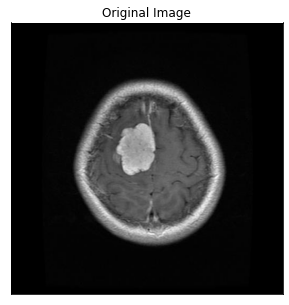

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


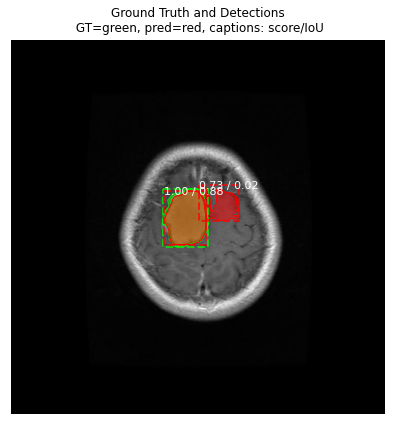

In [ ]:
display_image(dataset_val, 0)
predict_and_plot_differences(dataset_val, 0)

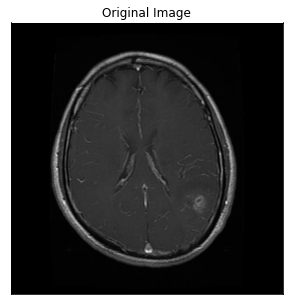

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


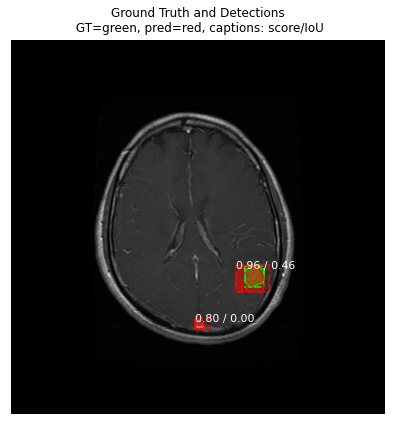

In [ ]:
display_image(dataset_val, 1)
predict_and_plot_differences(dataset_val, 1)

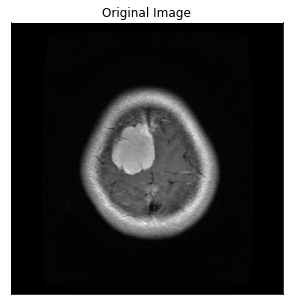

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


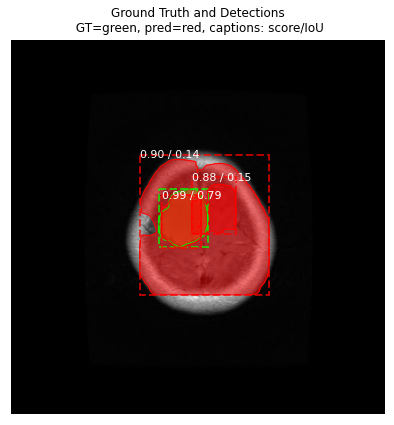

In [ ]:
display_image(dataset_val, 2)
predict_and_plot_differences(dataset_val, 2)

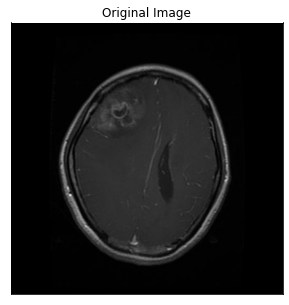

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


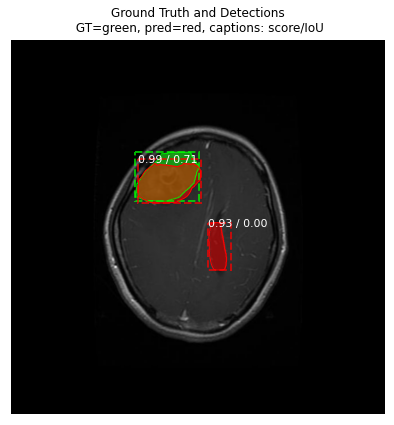

In [ ]:
display_image(dataset_val, 3)
predict_and_plot_differences(dataset_val, 3)